# Prevendo o valor do Bitcoin com LSTM

#### As criptomoedas são um dos investimentos mais em alta do momento, mas sua volatilidade ainda amedronta muitas investidores.
##### Pensando nisso, vamos usar um modelo de Machine Learning para conseguirmos prever os valores da cripto mais famosa: *o Bitcoin*!


###### E para isso usaremos a famosa: 
###### Long short-term memory (LSTM), que é uma arquitetura artificial do tipo RNN (recurrent neural network) usada na área do Deep Learning.

Primeiramente, vamos importar todas as bibliotes necessárias, como o *matplotlib* para a visualização dos dados, *tensorflow* para métodos de ML e *sklearn* para algumas funções bem úteis.

In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import product
from itertools import cycle

# import plotly.offline as py
# import plotly.graph_objects as go
# import plotly.express as px
# from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')


##### Agora vamos ler o arquivo, dando sequência em uma análise básica sobre nossos dados.

In [2]:
df = pd.read_csv('btc_2015_2021.csv')
df

,time,low,high,open,close,volume
0,2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079
1,2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357
2,2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848
3,2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070
4,2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128
...,...,...,...,...,...,...
3113271,2015-10-27 00:04:00,287.07,287.07,287.07,287.07,0.086100
3113272,2015-10-27 00:03:00,287.08,287.09,287.08,287.09,0.554400
3113273,2015-10-27 00:02:00,286.89,287.10,287.10,286.89,72.403200
3113274,2015-10-27 00:01:00,287.09,287.09,287.09,287.09,0.822760


In [3]:
df.describe()

,low,high,open,close,volume
count,3.113276e+06,3.113276e+06,3.113276e+06,3.113276e+06,3.113276e+06
mean,1.152825e+04,1.154230e+04,1.153537e+04,1.153541e+04,9.689568e+00
std,1.490292e+04,1.492446e+04,1.491374e+04,1.491379e+04,2.239875e+01
min,6.000000e-02,6.000000e-02,6.000000e-02,6.000000e-02,1.000000e-08
25%,1.849557e+03,1.850000e+03,1.849925e+03,1.849980e+03,1.331197e+00
50%,7.099990e+03,7.105000e+03,7.102045e+03,7.102060e+03,3.707298e+00
75%,1.067558e+04,1.068550e+04,1.068027e+04,1.068040e+04,9.761575e+00
max,6.690000e+04,6.699900e+04,6.694122e+04,6.694122e+04,1.549613e+03


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113276 entries, 0 to 3113275
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    object 
 1   low     float64
 2   high    float64
 3   open    float64
 4   close   float64
 5   volume  float64
dtypes: float64(5), object(1)
memory usage: 142.5+ MB


In [5]:
# Caso deseja, você pode converter essa coluna para datetime, mas então terá que refazer a forma de buscar os dias e horas
# df = df.astype({'time': 'datetime64'}) 
# df.info()

In [6]:
print('Valores nulos:',df.isnull().values.sum())
print('Existem valores NA?', df.isnull().values.any())

Valores nulos: 0
Existem valores NA? False


In [7]:
# Usaremos essas colunas dependendo da forma desejada de agrupar os dados (minutos, horas, dias)
df['data'] = df['time'].str.split().str[0]
df['data_e_horas'] = df['time'].str[:12]

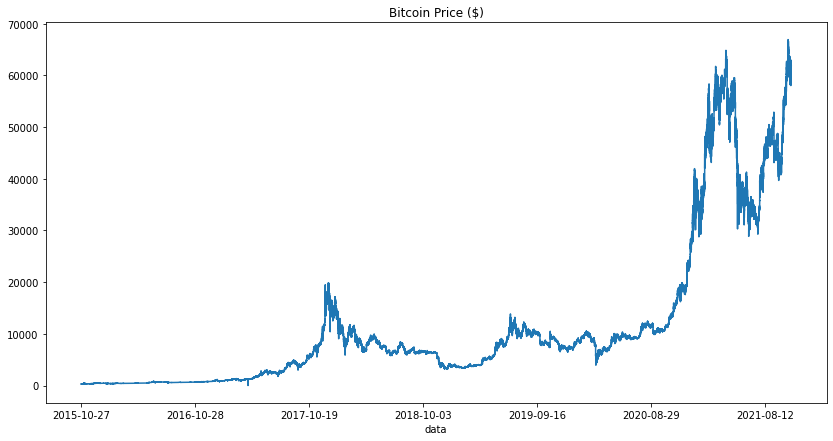

In [8]:
df.sort_values('time',inplace=True,ignore_index=True)

df.set_index('data')['close'].plot(figsize=(14,7),title='Bitcoin Price ($)');


# Lag Plots

Lag plots são usados para observar a autocorrelação de uma variável, algo que pode ser muito útil para compreender melhor nossos dados. 

Vamos usar essa ferramenta para observar a variação dos valores de 'fechamento' dos preços do BitCoin de acordo com o minuto, hora, dia, semana e mês.  

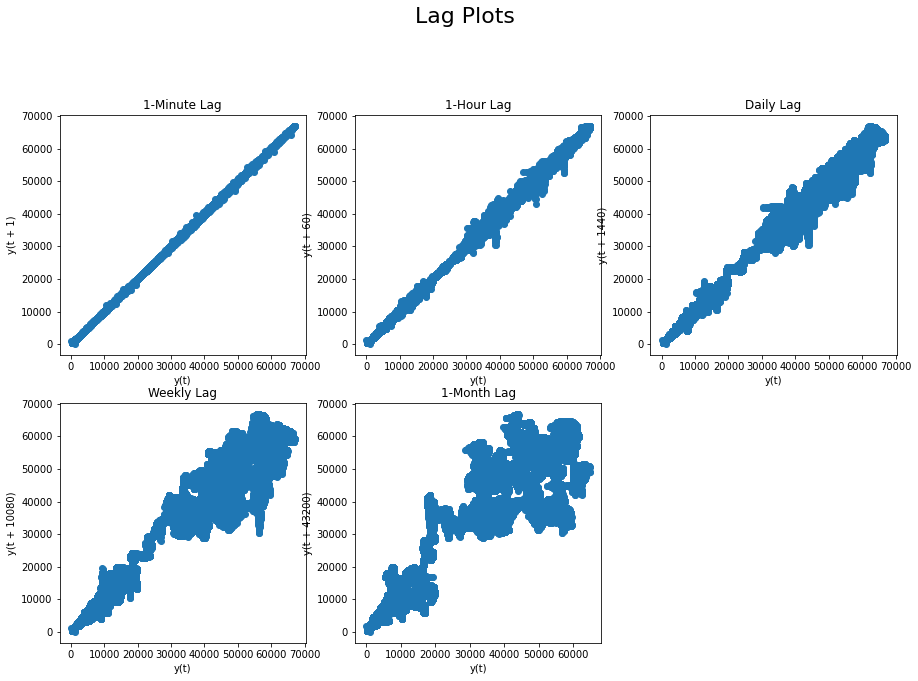

In [9]:
plt.figure(figsize=(15,15))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(df['close'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(df['close'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(df['close'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(df['close'], lag=10080) #weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,5)
pd.plotting.lag_plot(df['close'], lag=43200) #month lag
plt.title('1-Month Lag')

plt.show()

Percebe-se que há uma correlação positiva dentro dos Lag Plots para o minuto, hora e dia.

A variação dos valores se torna muito grande nos outros plots, então não vamos tentar agruprar os dados de acordo com a semana ou mês.



Talvez você não tenha percebido, mas os nossos dados não estão organizados cronolicamente. Para que possamos usar o LSTM, temos que resolver isso.

Podemos escolher fazer nosso predição com base nos minutos, horas ou dias, então já fiz o código necessário para cada opção:

#### Perceba que no DataFrame cada dia só possui o registro de 3 horas: detalhe que não podemos esquecer se quisermos trabalhar com as horas ou os minutos!


In [10]:
# POR DIAS:
# df_close = df.groupby('data')['close'].mean()
# dias_60 = 60 

# POR HORAS:
df_close = df.groupby('data_e_horas')['close'].mean()
dias_60 = 60 * 3 # Pois cada dia possui apenas 3 horas no nosso DataFrame.

# POR MINUTOS:
# df_close = df['close']
# dias_60 = 60 * 3 * 60 # Mesmo possuindo apenas 3 horas, cada hora ainda apresenta 60 minutos.


In [11]:
df_test = df_close[-dias_60:].values.reshape(-1,1) # Os últimos 60 dias
df_train = df_close[:-dias_60].values.reshape(-1,1) # Todos os dias, menos os últimos 60

df_test.shape

(180, 1)

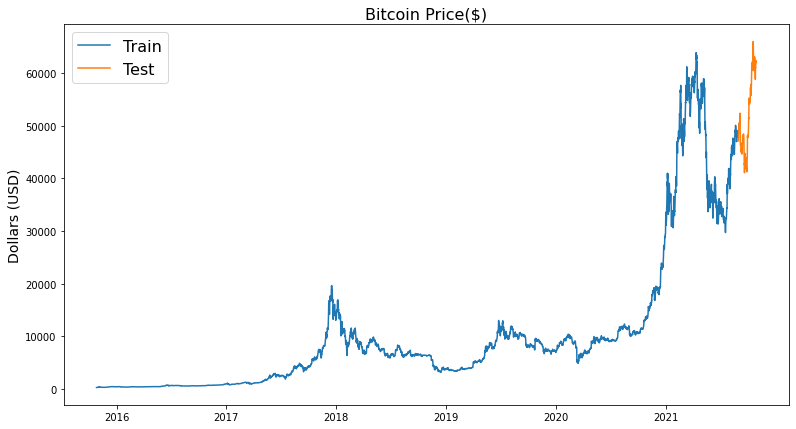

In [12]:
tamanho = len(df_close)

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(df_train, label='Train')
ax.plot(range(tamanho-dias_60,tamanho),df_test, label='Test')
ax.set_ylabel('Dollars (USD)', fontsize=14)
ax.set_title('Bitcoin Price($)', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.xticks(range(200,tamanho+100,tamanho//6),[2016,2017,2018,2019,2020,2021])
plt.show()

# Mix-Max Scaling dos dados após a divisão Train-Test 

Precisamos dividir os dados antes da normalização para que não ocorra um 'data leakage', ou seja, vazamento dos dados teste para os dados de treino. 

Isso ocorreria pois a normalização usaria parte dos dados teste como referência, mas como já separamos os dados, não teremos problema.


In [13]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [14]:
scaled_test

array([[0.25878601],
       [0.24203776],
       [0.24402618],
       [0.27605574],
       [0.29710812],
       [0.34360448],
       [0.34915023],
       [0.34248372],
       [0.33172587],
       [0.37750473],
       [0.36000071],
       [0.36492616],
       [0.35929818],
       [0.36272536],
       [0.35766093],
       [0.37097853],
       [0.42023663],
       [0.43016314],
       [0.42488391],
       [0.44836092],
       [0.45405998],
       [0.31400586],
       [0.22734305],
       [0.21136703],
       [0.21024751],
       [0.20871304],
       [0.20455151],
       [0.22621218],
       [0.21562881],
       [0.21839215],
       [0.18817281],
       [0.15605832],
       [0.16569756],
       [0.18305813],
       [0.16809137],
       [0.17224347],
       [0.19630638],
       [0.18300269],
       [0.15498044],
       [0.14234868],
       [0.15954262],
       [0.17336095],
       [0.21541919],
       [0.2318721 ],
       [0.2428319 ],
       [0.2731495 ],
       [0.28420037],
       [0.283

Vamos criar uma função que irá dividir o dataset entre os valores relacionados ao 'lookback period' e o valor que queremos descobrir.

Ou seja, usaremos os valores anteriores de uma sequência para adivinhar o valor seguinte.

In [15]:
def dataset_generator_lstm(dataset, look_back=10):
    # O “lookback” é o conceito no LSTM que define quantos dados usaremos para avaliar a informação seguinte,
    # nesse caso defini como 5, mas sinta-se avontade para testar outros valores.
    
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # esse é o valor do 'y' que vamos prever
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train)

testX, testY = dataset_generator_lstm(scaled_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (6391, 10)
trainY:  (6391,)
testX:  (170, 10)
testY (170,)


### Para usar o LSTM, é necessário que o input usado seja  um Tensor 3D de [samples, time steps, features]!

###### Samples --> Tamanho da amosta
###### Time steps --> Lookback period
###### Features --> Quantidade de 'features' observadas ( no nosso caso só queremos saber o preço do Bitcoin, então apenas 1 )

In [16]:
print(trainX.shape)
print(testX.shape)

(6391, 10)
(170, 10)


In [17]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (6391, 10, 1)
Shape of testX:  (170, 10, 1)


In [18]:
print("testX: ", testX) # Perceba que o último elemento do primeiro array (0.27041632) é o nono valor do segundo array,
                        # o que significa que a lógica do LSTM foi aplicada corretamente

testX:  [[[0.25878601]
  [0.24203776]
  [0.24402618]
  ...
  [0.34248372]
  [0.33172587]
  [0.37750473]]

 [[0.24203776]
  [0.24402618]
  [0.27605574]
  ...
  [0.33172587]
  [0.37750473]
  [0.36000071]]

 [[0.24402618]
  [0.27605574]
  [0.29710812]
  ...
  [0.37750473]
  [0.36000071]
  [0.36492616]]

 ...

 [[0.86832008]
  [0.8565841 ]
  [0.80752339]
  ...
  [0.80328145]
  [0.79998343]
  [0.80811464]]

 [[0.8565841 ]
  [0.80752339]
  [0.77636633]
  ...
  [0.79998343]
  [0.80811464]
  [0.82835944]]

 [[0.80752339]
  [0.77636633]
  [0.71717876]
  ...
  [0.80811464]
  [0.82835944]
  [0.85512691]]]


### Agora que já estruturamos todos os dados, finalmente podemos começar a construir o modelo!

In [19]:
regressor = Sequential()

# Vamos adicionar a primeira camada do LSTM e a regulaização do Dropout
# É necessário que 'return_sequences=True' quando empilhamos camadas de LSTM para que a camada seguinte 
# tenha a sequência de inputs com dimensão compatível.
# Logo, esse parâmetro deve ser 'False' apenas na última camada.

regressor.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

# Vamos adicionar a segunda camada e a regulaização do Dropout
regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

# Vamos adicionar a terceira camada e a regulaização do Dropout
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))

# Vamos adicionar a quarta camada e a regulaização do Dropout
# regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))

# Adicionando a camada do Output:
regressor.add(Dense(units = 1))

regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


#### Usaremos dois métodos referentes ao 'callbacks' do TensorFlow para que o modelo seja testado diversas vezes, nos permitindo acesso à sua versão mais otimizada.

O parâmetro 'epochs' do método fit se refere a quantidade de testes realizados.

O parâmetro 'patience' do método EarlyStopping se refere a quantidade de testes em sequência onde não há uma melhora do valor observado ( nesse caso é o 'val_loss' que se encontra no parâmetro 'monitor' ) que devem ocorrer para que os testes parem antes na quantidade especificada nos 'epochs' .


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compilando o LSTM
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

checkpoint_path = 'my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]


history = regressor.fit(trainX, trainY, batch_size = 32, epochs = 300, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/300
195/200 [============================>.] - ETA: 0s - loss: 0.0026
Epoch 00001: val_loss improved from inf to 0.05062, saving model to my_best_model.hdf5
200/200 [==============================] - 4s 9ms/step - loss: 0.0036 - val_loss: 0.0506
Epoch 2/300
199/200 [============================>.] - ETA: 0s - loss: 0.0100
Epoch 00002: val_loss improved from 0.05062 to 0.04106, saving model to my_best_model.hdf5
200/200 [==============================] - 1s 7ms/step - loss: 0.0103 - val_loss: 0.0411
Epoch 3/300
199/200 [============================>.] - ETA: 0s - loss: 0.0069
Epoch 00003: val_loss improved from 0.04106 to 0.03496, saving model to my_best_model.hdf5
200/200 [==============================] - 1s 7ms/step - loss: 0.0071 - val_loss: 0.0350
Epoch 4/300
198/200 [============================>.] - ETA: 0s - loss: 0.0061
Epoch 00004: val_loss improved from 0.03496 to 0.02302, saving model to my_best_model.hdf5
200/200 [==============================] - 1s 7ms/step - loss

Epoch 00034: val_loss did not improve from 0.00537
200/200 [==============================] - 2s 8ms/step - loss: 0.0022 - val_loss: 0.0065
Epoch 35/300
197/200 [============================>.] - ETA: 0s - loss: 0.0024  
Epoch 00035: val_loss did not improve from 0.00537
200/200 [==============================] - 2s 8ms/step - loss: 0.0024 - val_loss: 0.0054
Epoch 36/300
194/200 [============================>.] - ETA: 0s - loss: 0.0019   
Epoch 00036: val_loss did not improve from 0.00537
200/200 [==============================] - 2s 8ms/step - loss: 0.0021 - val_loss: 0.0056
Epoch 37/300
199/200 [============================>.] - ETA: 0s - loss: 0.0019  
Epoch 00037: val_loss improved from 0.00537 to 0.00476, saving model to my_best_model.hdf5
200/200 [==============================] - 2s 8ms/step - loss: 0.0019 - val_loss: 0.0048
Epoch 38/300
194/200 [============================>.] - ETA: 0s - loss: 0.0016   
Epoch 00038: val_loss did not improve from 0.00476
200/200 [==============

In [21]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model(checkpoint_path)

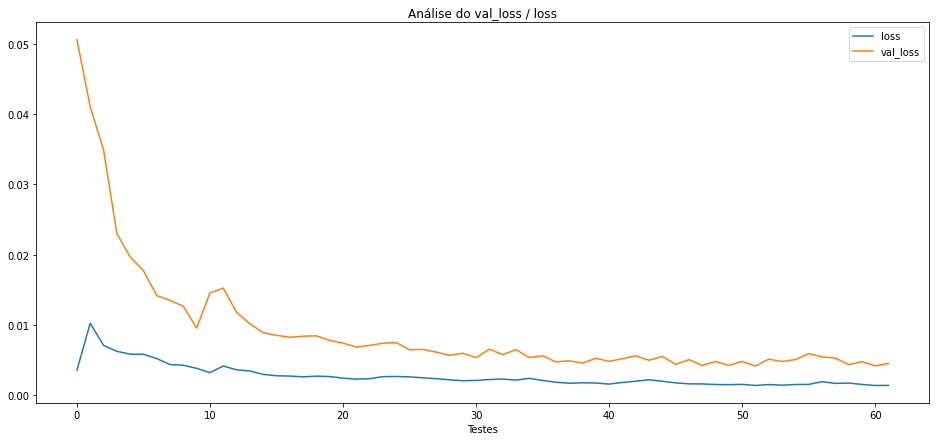

In [31]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Testes')
plt.title('Análise do val_loss / loss')
plt.show()

In [23]:
# Retornando os valores ao seus tamanhos reais, para finalmente realizar a predição

# predicted_btc_price_test_data = regressor.predict(testX)
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)

predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))

test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))

In [35]:
dias = df.data.unique()
dias_10 = [dias[-60 + x] for x in range(0,60,10)]

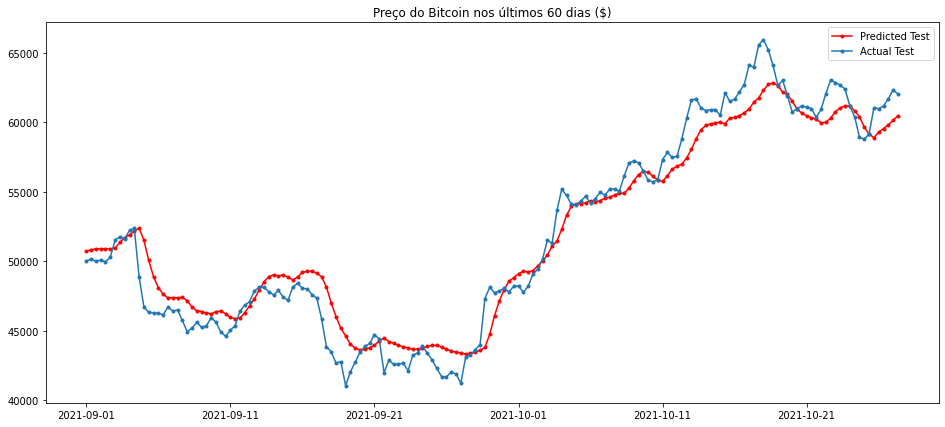

In [36]:
plt.figure(figsize=(16,7))
plt.title('Preço do Bitcoin nos últimos 60 dias ($)')
plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
plt.plot(test_actual, marker='.', label='Actual Test')
plt.xticks(range(0,df_test.shape[0],df_test.shape[0]//6),dias_10)
plt.legend()
plt.show()

In [26]:
# Retornando os valores de treino ao seus tamanhos reais, para compararmos as predições com os dados utilizados inicialmente.

predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)

predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))

train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))

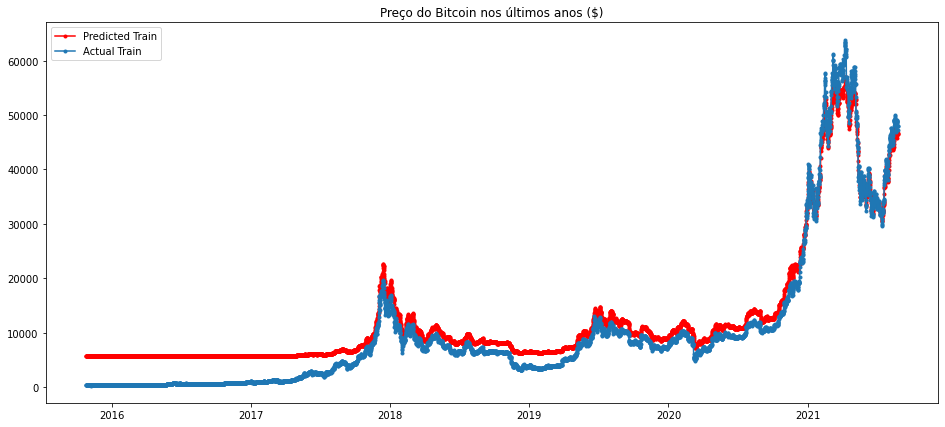

In [27]:
plt.figure(figsize=(16,7))
plt.title('Preço do Bitcoin nos últimos anos ($)')
plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')
plt.plot(train_actual, marker='.', label='Actual Train')
plt.xticks(range(200,tamanho+100,tamanho//6),[2016,2017,2018,2019,2020,2021])
plt.legend()
plt.show()

In [28]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)

# Usando os dias, 2 Layers + Dropout + lookback=5 => Test RMSE: 2006.598
# Usando os dias, 2 Layers + Dropout + lookback=10 => Test RMSE: 1982.576

# Usando as horas, 2 Layers + Dropout + lookback=5 => Test RMSE: 2088.866  
# Usando as horas, 2 Layers + Dropout + lookback=10 => Test RMSE: 1608.899 (Melhor)

# Não consegui testar com os minutos pois foram mais de 3 milhões de linhas a serem analisadas,
# sobrecarregando as capacidades do meu computador.

Test RMSE: 1608.899


In [29]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))

print('Train RMSE: %.3f' % rmse_lstm_train)

# Usando os dias, 2 Layers + Dropout + lookback=5 => Train RMSE: 1425.244 
# Usando os dias, 2 Layers + Dropout + lookback=10 => Train RMSE: 1932.516 

# Usando as horas, 2 Layers + Dropout + lookback=5 => Train RMSE: 3225.320
# Usando as horas, 2 Layers + Dropout + lookback=10 => Train RMSE: 3250.291

Train RMSE: 3250.291


In [32]:
len(predicted_btc_price_test_data)

170